In [1]:
import os
import sys
#path environment
if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")
import traci

import xml.etree.ElementTree as ET

import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.api as sm
import numpy as np

In [2]:
file_output = 'my_output_file_grid_dinamico.xml'
sumo_cmd = ['sumo', 
            '--duration-log.statistics', 
            '--tripinfo-output', file_output, 
            '-c', 'maps/grid/grid.sumo.cfg']

In [3]:
def reroute_vehicle(vehicle_id):
    try:
        current_edge = traci.vehicle.getRoadID(vehicle_id)
        
        # Get the current route of the vehicle
        current_route = traci.vehicle.getRoute(vehicle_id)

        if current_edge not in current_route:
            # If the current edge is not in the route, dynamically find a new route
            print(f"Warning: Vehicle {vehicle_id} is not on a known route edge. Attempting to reroute.")
            
            # Attempt to find a new route to the destination
            destination = traci.vehicle.getRoute(vehicle_id)[-1]
            new_route = traci.simulation.findRoute(current_edge, destination).edges

            if new_route:
                traci.vehicle.setRoute(vehicle_id, new_route)
                print(f"Vehicle {vehicle_id} rerouted to new path: {new_route}")
            return

        current_index = current_route.index(current_edge)
        
        # Initialize variables to store the best alternative route
        best_route = current_route
        min_time_loss = float('inf')

        # Fetch alternative routes starting from the current edge
        for edge in current_route[current_index:]:
            # Check if edge is less congested
            edge_density = traci.edge.getLastStepVehicleNumber(edge) / traci.edge.getLaneNumber(edge)
            if edge_density < 0.5:  # Example threshold for low congestion
                # Estimate time loss on this route
                time_loss = sum(traci.edge.getTraveltime(e) for e in current_route[current_index:])
                
                # Update best route if this one has lower time loss
                if time_loss < min_time_loss:
                    min_time_loss = time_loss
                    best_route = current_route[current_index:]

        # Set the new route if it's different and has less time loss
        if best_route != current_route:
            traci.vehicle.setRoute(vehicle_id, best_route)

    except traci.exceptions.TraCIException as e:
        print(f"TraCIException for vehicle {vehicle_id}: {str(e)}")
    except ValueError as e:
        print(f"ValueError for vehicle {vehicle_id}: {str(e)}")

# Use the function in your simulation loop


In [4]:
def analyze_time_loss(file_path):
    # Parse the XML file
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Initialize variables for analysis
    total_time_loss = 0.0
    total_waiting_time = 0.0
    total_duration = 0.0
    total_reroutes = 0
    vehicle_count = 0

    # Iterate over each tripinfo element in the XML
    for trip in root.findall('tripinfo'):
        time_loss = float(trip.get('timeLoss'))
        waiting_time = float(trip.get('waitingTime'))
        duration = float(trip.get('duration'))
        reroutes = int(trip.get('rerouteNo'))
        
        total_time_loss += time_loss
        total_waiting_time += waiting_time
        total_duration += duration
        total_reroutes += reroutes
        vehicle_count += 1

    # Calculate averages
    average_time_loss = total_time_loss / vehicle_count if vehicle_count > 0 else 0
    average_waiting_time = total_waiting_time / vehicle_count if vehicle_count > 0 else 0
    average_duration = total_duration / vehicle_count if vehicle_count > 0 else 0
    average_reroutes = total_reroutes / vehicle_count if vehicle_count > 0 else 0

    # Store results in a dictionary
    results = {
        'Total Vehicles': vehicle_count,
        'Total Time Loss': total_time_loss,
        'Average Time Loss': average_time_loss,
        'Total Waiting Time': total_waiting_time,
        'Average Waiting Time': average_waiting_time,
        'Average Duration': average_duration,
        'Total Reroutes': total_reroutes,
        'Average Reroutes': average_reroutes
    }
    return results


In [5]:
reroute_intervals = [5,10,15,20,30,40,50, 60, 120]  # Different intervals to test
STEPTOTAL = 3600
simulation_results = []

for reroute_interval in reroute_intervals:
    print(f"Running simulation with reroute interval: {reroute_interval} seconds")
    
    # Start SUMO
    traci.start(sumo_cmd)

    step = 0
    try:
        while step < STEPTOTAL:
            traci.simulationStep()
    
            if step % reroute_interval == 0:
                for vehicle_id in traci.vehicle.getIDList():
                    reroute_vehicle(vehicle_id)
    
            step += 1
    finally:
        traci.close()


    
    # Analyze the results and store them in the simulation_results list
    results = analyze_time_loss(file_output)
    results['Reroute Interval'] = reroute_interval  # Add the interval as a data point
    simulation_results.append(results)



Running simulation with reroute interval: 5 seconds
 Retrying in 1 seconds
***Starting server on port 49441 ***
Loading net-file from 'maps/grid/grid.net.xml' ... done (60ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.
Vehicle veh1 rerouted to new path: (':C9_5', 'C9C8', 'C8C7', 'C7C6', 'C6C5', 'C5C4', 'C4C3', 'C3D3')
Vehicle veh3 rerouted to new path: (':H7_5', 'H7G7', 'G7F7', 'F7F6', 'F6F5', 'F5F4', 'F4F3', 'F3F2', 'F2F1', 'F1E1', 'E1D1', 'D1C1', 'C1B1', 'B1A1')
Vehicle veh11 rerouted to new path: (':E4_15', 'E4D4', 'D4C4', 'C4B4', 'B4B5', 'B5B6', 'B6B7', 'B7A7')
Vehicle veh12 rerouted to new path: (':J3_0', 'J3I3', 'I3H3', 'H3G3', 'G3F3', 'F3E3', 'E3D3', 'D3D4', 'D4D5')
Vehicle veh13 rerouted to new path: (':B2_11', 'B2B1', 'B1C1')
Vehicle veh0 rerouted to new path: (':F2_5', 'F2E2', 'E2D2', 'D2C2', 'C2B2', 'B2A2', 'A2A3', 'A3A4')
Vehicle veh15 rerouted to new path: (':I8_12', 'I8I7', 'I7I6', 'I6I5', 'I5I4', 'I4I3', 'I3I2', 'I2I1', 'I1H1', 'H1I1')
Vehicle veh16

In [6]:
# Convert results to a DataFrame
df = pd.DataFrame(simulation_results)
df

Total Vehicles  Total Time Loss  Average Time Loss  Total Waiting Time  \
0            3452         78430.61          22.720339              7673.0   
1            3452         79721.42          23.094270              8385.0   
2            3453         79411.93          22.997953              8055.0   
3            3456         80331.42          23.244045              8748.0   
4            3452         80596.27          23.347703              9542.0   
5            3450         79133.99          22.937388              8078.0   
6            3456         80027.87          23.156212              8839.0   
7            3454         78469.17          22.718347              7470.0   
8            3455         79582.96          23.034142              8211.0   

   Average Waiting Time  Average Duration  Total Reroutes  Average Reroutes  \
0              2.222769        143.205968            3796          1.099652   
1              2.429027        143.780127            3638          1.053882   
2              2.332754        143.500434            3565          1.032436   
3              2.531250        143.564236            3539          1.024016   
4              2.764195        143.876304            3508          1.016222   
5              2.341449        143.404638            3484          1.009855   
6              2.557581        143.543692            3480          1.006944   
7              2.162710        143.509844            3451          0.999131   
8              2.376556        143.373661            3442          0.996237   

   Reroute Interval  
0                 5  
1                10  
2                15  
3                20  
4                30  
5                40  
6                50  
7                60  
8               120

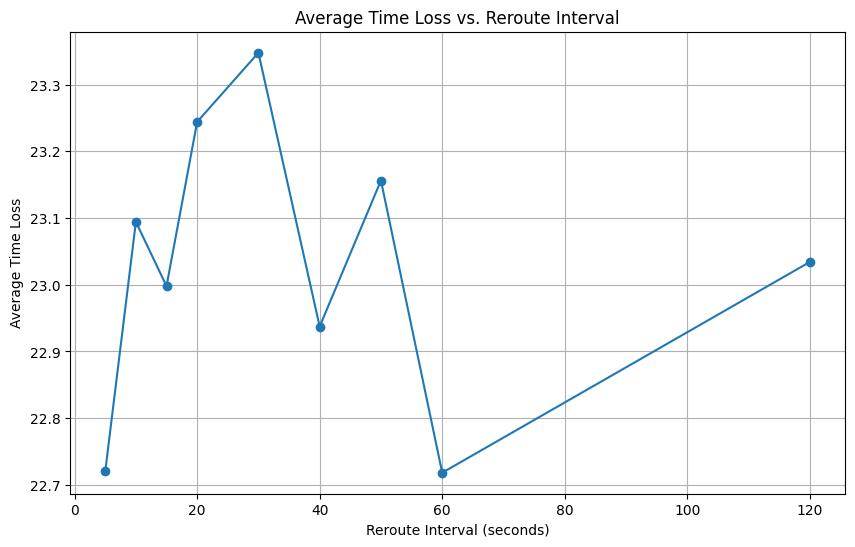

In [7]:


plt.figure(figsize=(10, 6))
plt.plot(df['Reroute Interval'], df['Average Time Loss'], marker='o')
plt.title('Average Time Loss vs. Reroute Interval')
plt.xlabel('Reroute Interval (seconds)')
plt.ylabel('Average Time Loss')
plt.grid(True)
plt.show()


In [8]:
# Display descriptive statistics
df.describe()

Total Vehicles  Total Time Loss  Average Time Loss  Total Waiting Time  \
count        9.000000         9.000000           9.000000            9.000000   
mean      3453.333333     79522.848889          23.027822         8333.444444   
std          2.061553       755.881067           0.214886          635.433535   
min       3450.000000     78430.610000          22.718347         7470.000000   
25%       3452.000000     79133.990000          22.937388         8055.000000   
50%       3453.000000     79582.960000          23.034142         8211.000000   
75%       3455.000000     80027.870000          23.156212         8748.000000   
max       3456.000000     80596.270000          23.347703         9542.000000   

       Average Waiting Time  Average Duration  Total Reroutes  \
count              9.000000          9.000000        9.000000   
mean               2.413143        143.528767     3544.777778   
std                0.183780          0.203184      112.275084   
min                2.162710        143.205968     3442.000000   
25%                2.332754        143.404638     3480.000000   
50%                2.376556        143.509844     3508.000000   
75%                2.531250        143.564236     3565.000000   
max                2.764195        143.876304     3796.000000   

       Average Reroutes  Reroute Interval  
count          9.000000          9.000000  
mean           1.026486         38.888889  
std            0.032735         35.600016  
min            0.996237          5.000000  
25%            1.006944         15.000000  
50%            1.016222         30.000000  
75%            1.032436         50.000000  
max            1.099652        120.000000

In [9]:
# Specific statistics for each reroute interval
grouped_stats = df.groupby('Reroute Interval').agg(['mean', 'std', 'min', 'max'])
grouped_stats

Total Vehicles                 Total Time Loss                \
                           mean std   min   max            mean std       min   
Reroute Interval                                                                
5                        3452.0 NaN  3452  3452        78430.61 NaN  78430.61   
10                       3452.0 NaN  3452  3452        79721.42 NaN  79721.42   
15                       3453.0 NaN  3453  3453        79411.93 NaN  79411.93   
20                       3456.0 NaN  3456  3456        80331.42 NaN  80331.42   
30                       3452.0 NaN  3452  3452        80596.27 NaN  80596.27   
40                       3450.0 NaN  3450  3450        79133.99 NaN  79133.99   
50                       3456.0 NaN  3456  3456        80027.87 NaN  80027.87   
60                       3454.0 NaN  3454  3454        78469.17 NaN  78469.17   
120                      3455.0 NaN  3455  3455        79582.96 NaN  79582.96   

                           Average Time Loss      ... Average Duration  \
                       max              mean std  ...              min   
Reroute Interval                                  ...                    
5                 78430.61         22.720339 NaN  ...       143.205968   
10                79721.42         23.094270 NaN  ...       143.780127   
15                79411.93         22.997953 NaN  ...       143.500434   
20                80331.42         23.244045 NaN  ...       143.564236   
30                80596.27         23.347703 NaN  ...       143.876304   
40                79133.99         22.937388 NaN  ...       143.404638   
50                80027.87         23.156212 NaN  ...       143.543692   
60                78469.17         22.718347 NaN  ...       143.509844   
120               79582.96         23.034142 NaN  ...       143.373661   

                             Total Reroutes                 Average Reroutes  \
                         max           mean std   min   max             mean   
Reroute Interval                                                               
5                 143.205968         3796.0 NaN  3796  3796         1.099652   
10                143.780127         3638.0 NaN  3638  3638         1.053882   
15                143.500434         3565.0 NaN  3565  3565         1.032436   
20                143.564236         3539.0 NaN  3539  3539         1.024016   
30                143.876304         3508.0 NaN  3508  3508         1.016222   
40                143.404638         3484.0 NaN  3484  3484         1.009855   
50                143.543692         3480.0 NaN  3480  3480         1.006944   
60                143.509844         3451.0 NaN  3451  3451         0.999131   
120               143.373661         3442.0 NaN  3442  3442         0.996237   

                                          
                 std       min       max  
Reroute Interval                          
5                NaN  1.099652  1.099652  
10               NaN  1.053882  1.053882  
15               NaN  1.032436  1.032436  
20               NaN  1.024016  1.024016  
30               NaN  1.016222  1.016222  
40               NaN  1.009855  1.009855  
50               NaN  1.006944  1.006944  
60               NaN  0.999131  0.999131  
120              NaN  0.996237  0.996237  

[9 rows x 32 columns]

In [10]:
# Compute correlation matrix
correlation_matrix = df.corr()

# Display correlation matrix
correlation_matrix

Total Vehicles  Total Time Loss  Average Time Loss  \
Total Vehicles              1.000000         0.320395           0.262264   
Total Time Loss             0.320395         1.000000           0.998153   
Average Time Loss           0.262264         0.998153           1.000000   
Total Waiting Time          0.173540         0.950437           0.957097   
Average Waiting Time        0.165803         0.949161           0.956293   
Average Duration           -0.024369         0.711165           0.726218   
Total Reroutes             -0.343650        -0.322157          -0.306295   
Average Reroutes           -0.359887        -0.326078          -0.309248   
Reroute Interval            0.388897        -0.014288          -0.039348   

                      Total Waiting Time  Average Waiting Time  \
Total Vehicles                  0.173540              0.165803   
Total Time Loss                 0.950437              0.949161   
Average Time Loss               0.957097              0.956293   
Total Waiting Time              1.000000              0.999969   
Average Waiting Time            0.999969              1.000000   
Average Duration                0.719681              0.721000   
Total Reroutes                 -0.240480             -0.238187   
Average Reroutes               -0.242196             -0.239775   
Reroute Interval               -0.076562             -0.079625   

                      Average Duration  Total Reroutes  Average Reroutes  \
Total Vehicles               -0.024369       -0.343650         -0.359887   
Total Time Loss               0.711165       -0.322157         -0.326078   
Average Time Loss             0.726218       -0.306295         -0.309248   
Total Waiting Time            0.719681       -0.240480         -0.242196   
Average Waiting Time          0.721000       -0.238187         -0.239775   
Average Duration              1.000000       -0.257140         -0.255085   
Total Reroutes               -0.257140        1.000000          0.999850   
Average Reroutes             -0.255085        0.999850          1.000000   
Reroute Interval             -0.213541       -0.699189         -0.701699   

                      Reroute Interval  
Total Vehicles                0.388897  
Total Time Loss              -0.014288  
Average Time Loss            -0.039348  
Total Waiting Time           -0.076562  
Average Waiting Time         -0.079625  
Average Duration             -0.213541  
Total Reroutes               -0.699189  
Average Reroutes             -0.701699  
Reroute Interval              1.000000

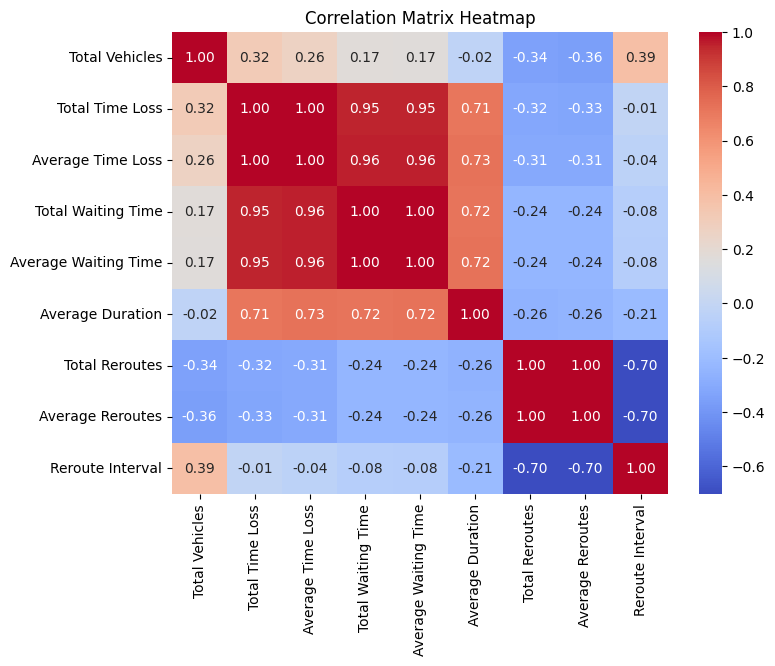

In [11]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()


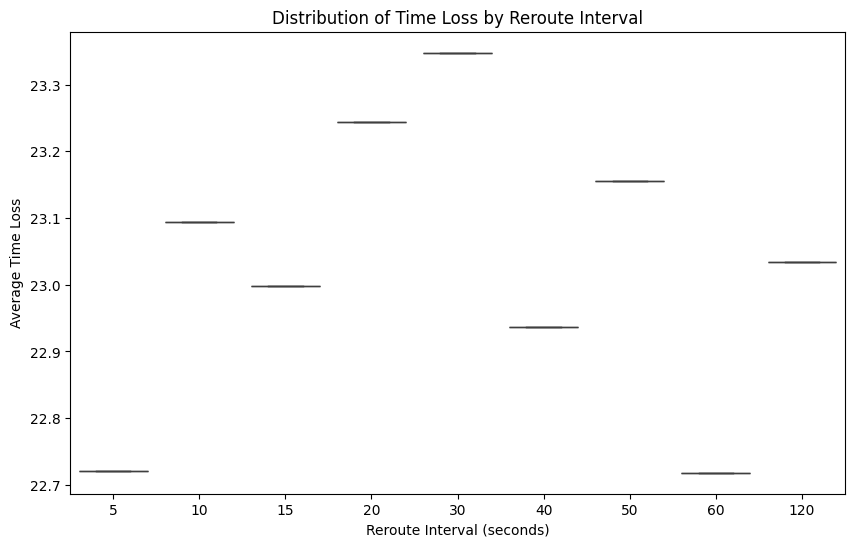

In [12]:


plt.figure(figsize=(10, 6))
sns.boxplot(x='Reroute Interval', y='Average Time Loss', data=df)
plt.title('Distribution of Time Loss by Reroute Interval')
plt.xlabel('Reroute Interval (seconds)')
plt.ylabel('Average Time Loss')
plt.show()


In [13]:
# Add a constant term for the intercept in the regression model
X = sm.add_constant(df['Reroute Interval'])
y = df['Average Time Loss']

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression analysis
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:      Average Time Loss   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.141
Method:                 Least Squares   F-statistic:                   0.01085
Date:                Sun, 11 Aug 2024   Prob (F-statistic):              0.920
Time:                        22:42:41   Log-Likelihood:                 1.6054
No. Observations:                   9   AIC:                            0.7892
Df Residuals:                       7   BIC:                             1.184
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               23.0371      0.117  

/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


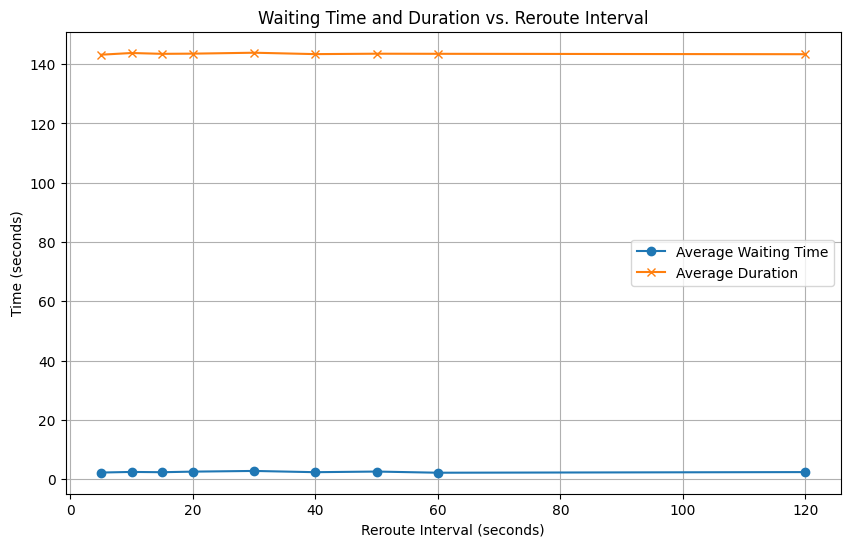

In [14]:
# Plot waiting time vs reroute interval
plt.figure(figsize=(10, 6))
plt.plot(df['Reroute Interval'], df['Average Waiting Time'], marker='o', label='Average Waiting Time')
plt.plot(df['Reroute Interval'], df['Average Duration'], marker='x', label='Average Duration')
plt.title('Waiting Time and Duration vs. Reroute Interval')
plt.xlabel('Reroute Interval (seconds)')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()


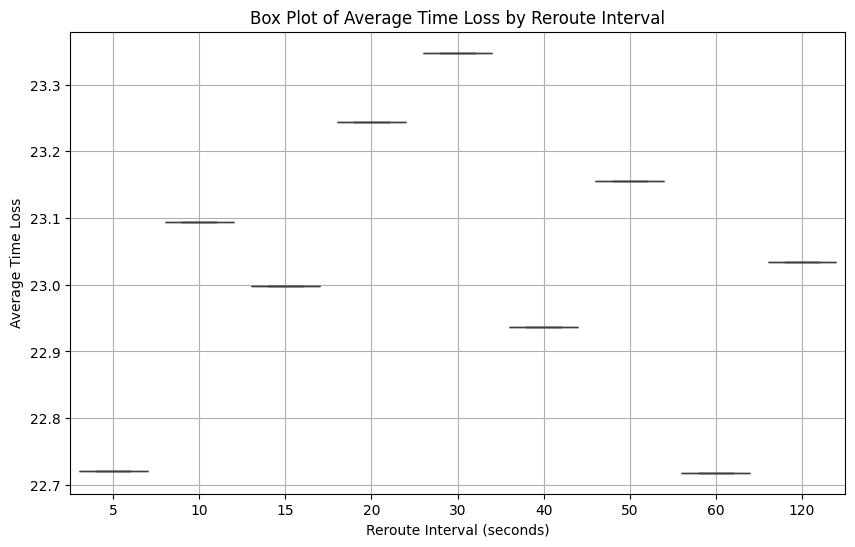

In [15]:
# Create a box plot for Average Time Loss vs. Reroute Interval
plt.figure(figsize=(10, 6))
sns.boxplot(x='Reroute Interval', y='Average Time Loss', data=df)
plt.title('Box Plot of Average Time Loss by Reroute Interval')
plt.xlabel('Reroute Interval (seconds)')
plt.ylabel('Average Time Loss')
plt.grid(True)

# Show the plot
plt.show()

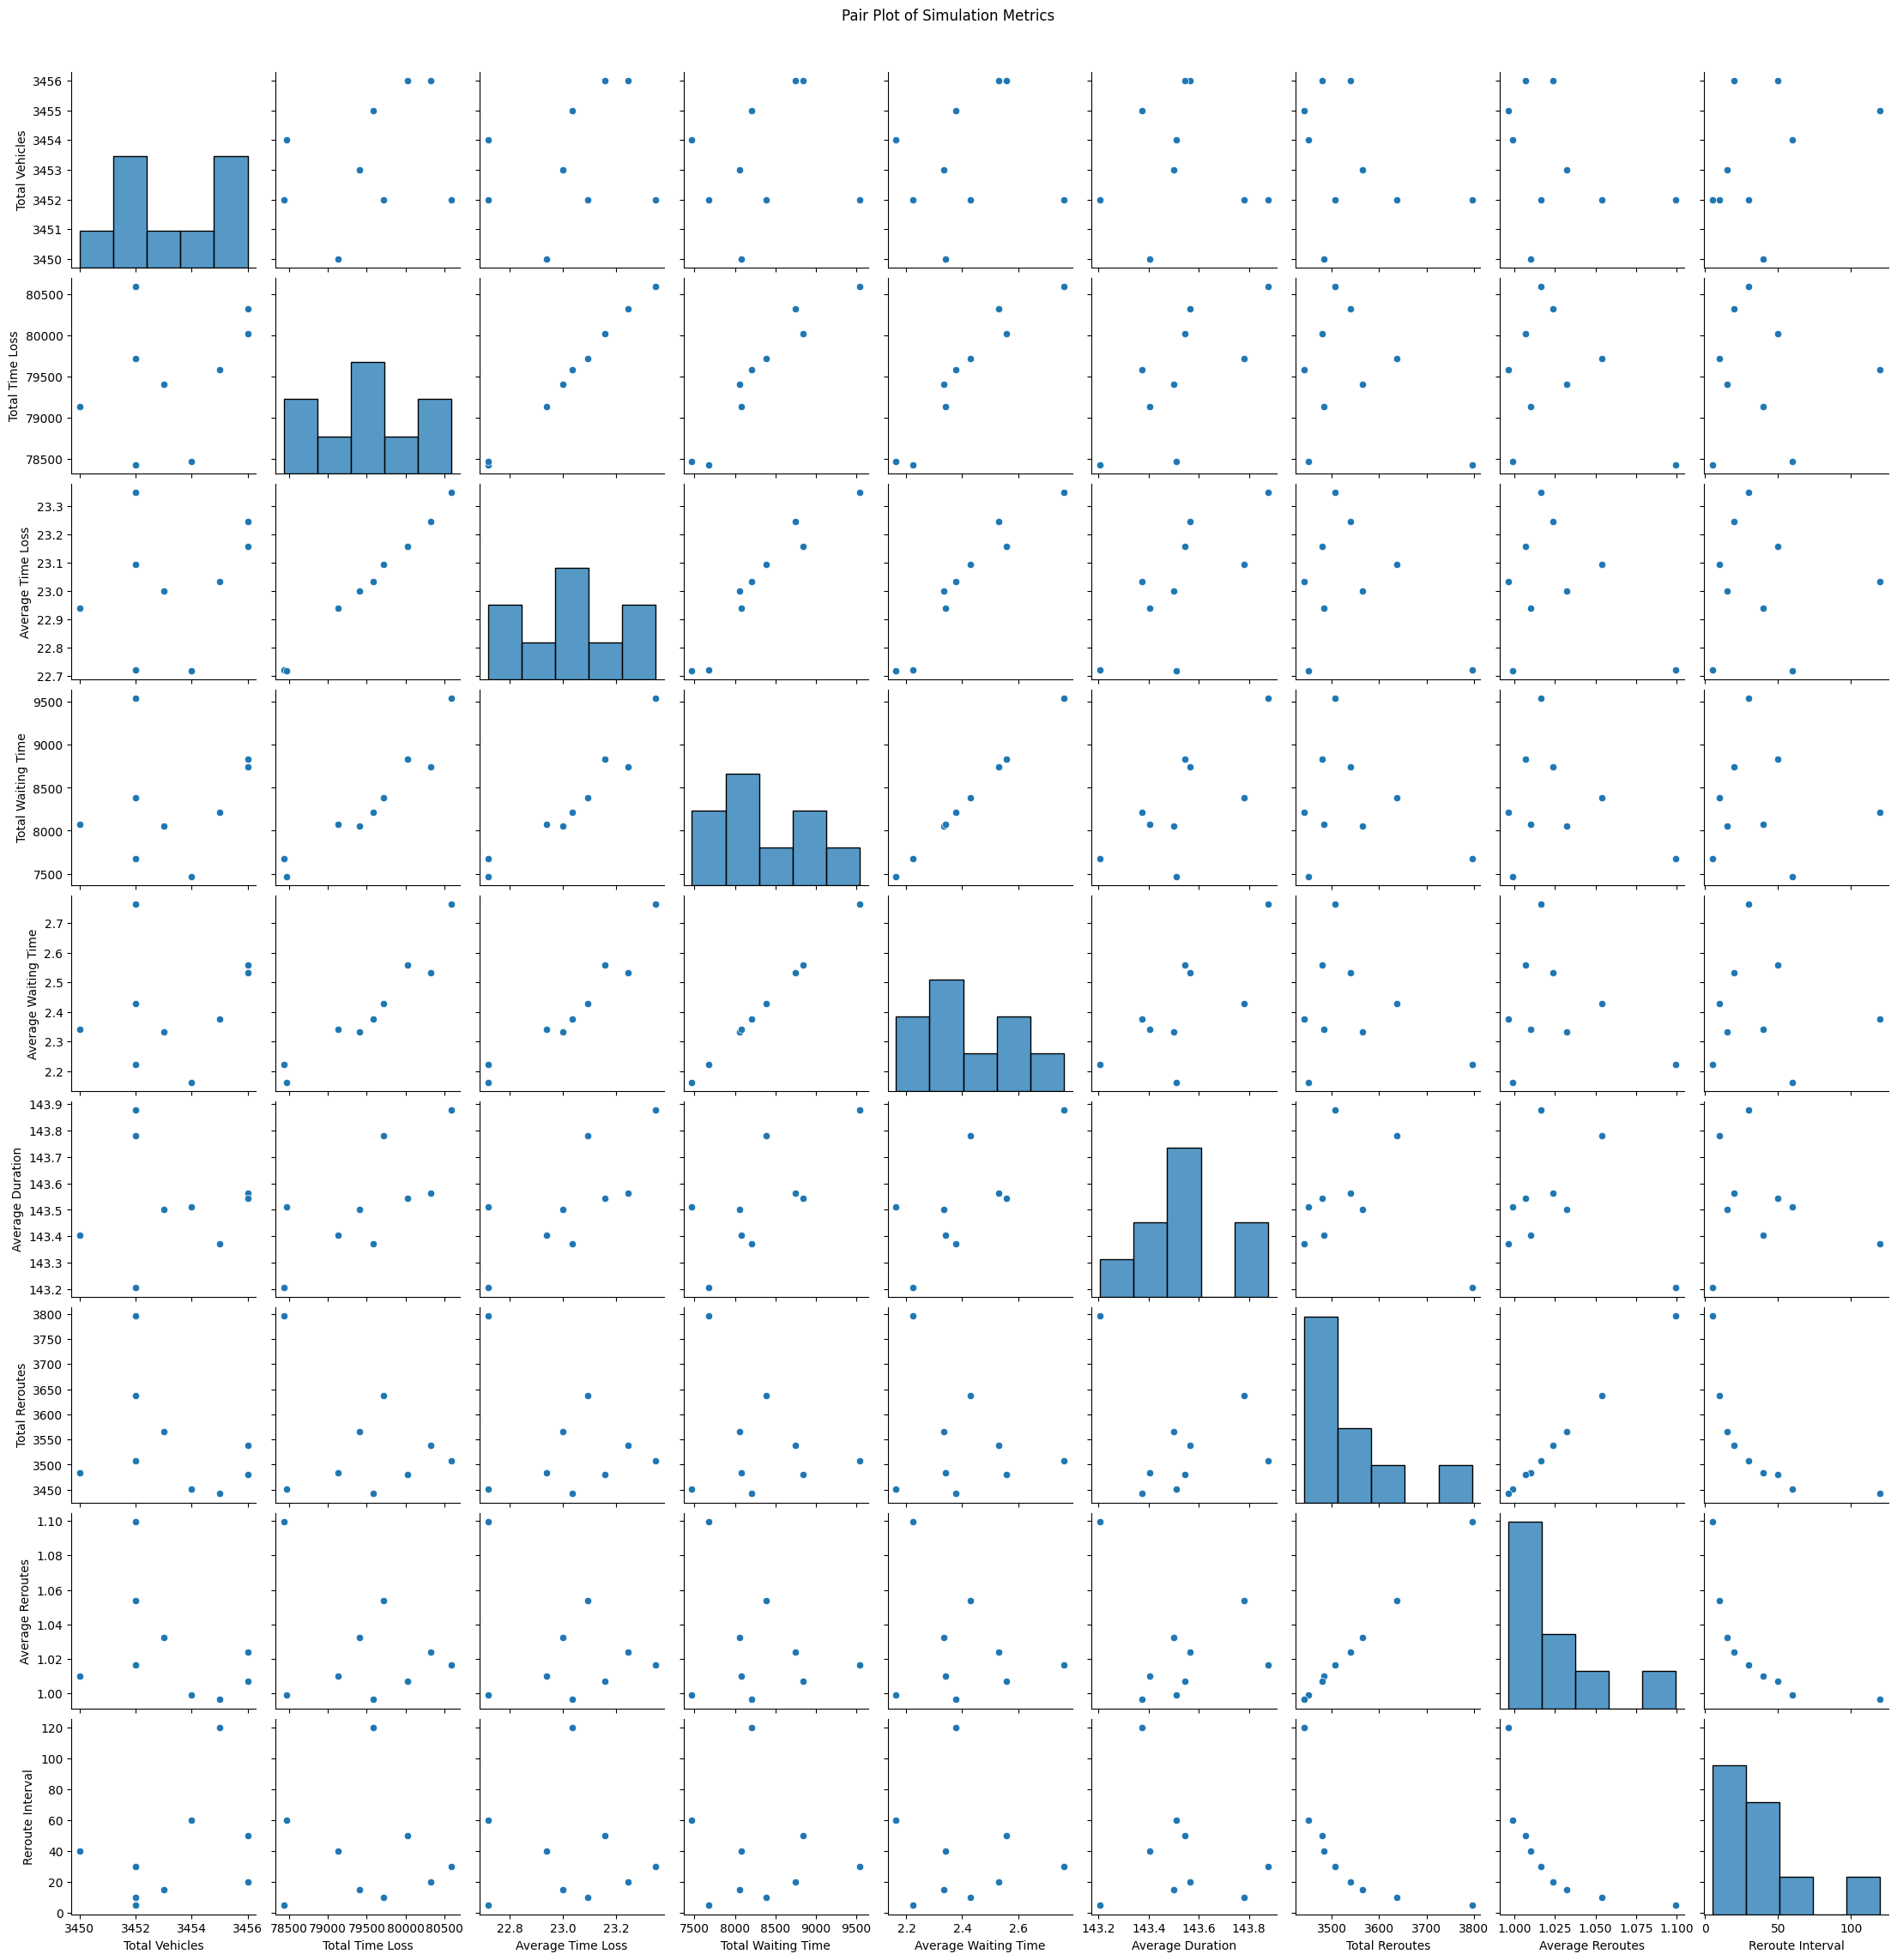

In [16]:
sns.pairplot(df)
plt.suptitle('Pair Plot of Simulation Metrics', y=1.02)
plt.show()